In Python, we need to import various libraries to help us with reading/manipulating data (Pandas), performing numerical calculations (NumPy) and plotting data (Matplotlib). For more information on all these libraries please see the course notes for GEOG-G489/589 Big Data Geospatial Analysis in Python: https://github.com/nmacbean/GEOG-G489-589

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Exercise 1: Building a simple carbon model

In this exercise we will write the code needed to build the simple two pool carbon model that was introduced here: https://github.com/nmacbean/GEOG-G440-540/blob/master/In-Class%20Exercises/Introduction%20to%20the%20simple%20C%20model.md

Learning outcomes:
- Learn how to set-up the model, including specifying parameters (fixed values of the model)
- Learn how to read in model input data and how to use an exploratory plotting analysis to examine those input data
- Learn how to code the model equations to run the model
- Plot resultant model simulations and answer questions to test understanding of model performance.

## Model Set-up

Before running the model we need to set-up various components of the model, including any model parameters (fixed values) in the model:

### Parameters

Here is a list of the 12 model parameters, their descriptions and units (where relevant):

#### Parameters for the environmental limitations
- Q10: Q10 temperature limitation on heterotrophic respiration (Rh)
- Tref: reference temperature for Q10 equation (Kelvin)
- Wf_m: 'm' coefficient for the moisture limitation on Rh  
- Wf_x0: 'x0' coefficient for the moisture limitation on Rh 
- Wf_min: minimum value for moisture limitation on Rh
- Wf_max: maximum value for moisture limitation on Rh

#### Parameters for the turnover time of each pool
- tau_litter: turnover time of the litter C pool (years)
- tau_soil: turnover time of the soil C pool (years)

#### Parameters for the microbial efficiency of each pool
- Me_litter: microbial efficiency of the litter pool (fraction)
- Me_soil: microbial efficiency of the soil pool (fraction)

#### Parameters for the initial carbon stock of each pool
- C_litter_t0: initial C stock of the litter pool (kgC/m2)
- C_soil_t0: initial C stock of the soil pool (kgC/m2)

#### Timestep
- dt = timestep

In [8]:
# -
# - set default parameters
# -
Q10 = 2.
Tref = 303.15    # 30 degrees C in K
Wf_m = -2.
Wf_x0 = 0.6
Wf_min = 0.05
Wf_max = 1.
tau_litter = 0.5
tau_soil = 60
Me_litter = 0.3
Me_soil = 0.1
C_litter_t0 = 3
C_soil_t0 = 22

# -
# - other 
# - 
dt = 1/365.
npools = 2

-------

## Model inputs (drivers/forcing)

Next, we need to read in the input data (i.e. the data that we will use to drive or run the model). Remember that for a full TEM run we would need various climate data "forcings".

To keep things simple for this model, we have five different sets of input data to this model:

1. Litter input from leaf turnover (during senescence) - units in file are gCm$^{-2}$dt$^{-1}$
2. Temperature in the litter layer - units in file are $^{\circ}$C
3. Moisture in the litter layer - units in file are in volumetric (or relative) water content (i.e. range from 0 to 1.)
4. Temperature in the soil layer
5. Moisture in the soil layer

Note that in a full TEM the temperature and the moisture would have been calculated in the energy budget and hydrology modules of the model. See the powerpoints slides on these two components for more information. The litter carbon input would have already been calculated as part of the complete carbon cycle part of the model. C uptake by the plants would have been calculated via the photosythesis and phenology modules, autotrophic respiration would have already occurred (to give NPP), the NPP would have been allocated to different aboveground biomass pools (leaves, stem etc). The litter input comes from the leaves (and any dead wood) that fall off the trees during the autumn each year.

First, we need to convert our input data into the right units. For example, the temperature needs to be in Kelvin and the litter input needs to be in kgC rather than gC given the C pools and fluxes in the model will be in kgC.

In [9]:
# - unit conversions
degC_to_K = 273.15
gC_to_kgC = 1e-3

Next, we need to read in the input data and convert the relevant variables to the correct units. This we do using the code below. We then print the first few lines of input data to see if everything looks ok.

In [10]:
# - read in inputs
input_file = 'carbon_2pool_model_inputs.csv'
input_data = pd.read_csv(input_file, index_col=0)

# - convert temperature to K
input_data.LITTER_TEMP += degC_to_K
input_data.SOIL_TEMP += degC_to_K

# - convert litter input to kgC
input_data.LITTER_INPUT *= gC_to_kgC

In [11]:
# - print out first few lines of input data
print(input_data.head())

       LITTER_INPUT  LITTER_TEMP  LITTER_MOIST   SOIL_TEMP  SOIL_MOIST
TSTEP                                                                 
0               0.0   269.764838      0.958876  270.663672    0.997947
1               0.0   275.324255      0.983762  273.570197    0.998970
2               0.0   281.750983      0.999995  278.072485    1.000000
3               0.0   282.473273      0.998394  279.588538    0.999838
4               0.0   270.587561      0.982143  274.326941    0.998997


Now we have read in the input data we can work out the number of timesteps in the input data, which we do using the following code. This will be important for calculating the C fluxes between pools, the heterotrophic respiration and the evolution of the two C pools over time.

In [12]:
# - calculate the number of timesteps from the input data
ntsteps = len(input_data.index)
print(ntsteps)

4015


**Question: why are there 4015 timesteps?** [Hint: think back to what I told you about the input data]

ANSWER: 

Now we want to plot the input data to see what they look like. In the box below I have used the matplotlib plotting library to plot the litter input data for the first 3 years.

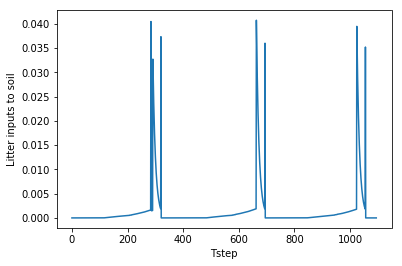

In [13]:
# plot litter input data for first 3 years (1095 days)
plt.plot(input_data.LITTER_INPUT[:1095])
plt.xlabel('Tstep')
plt.ylabel('Litter inputs to soil')
plt.show()

**Question: why do the litter input data look like this (with spikes at certain times of the year)?**

ANSWER: 

**Exercise: in the box below, copy and modify the code above to plot the temperature and moisture input data for the litter layer.** Check that the time series of temperature and moisture data make sense to you given the site location of the data. If not, ask me.

In [14]:
# - write code here


-------
-------

## Model Code

In the next sections we will examine the relevant equations needed to set up the model as well as the code we use to implement the equations and run the model.

### Model equations for the environmental limitation functions

As we saw in the introduction to the model, here are the following equations for the temperature and moisture limitation functions:

#### Temperature limitation equation
\begin{equation*}
f(T) = Q10^{((T_{Cpool}-30)/10)}
\end{equation*}

*where T$_{Cpool}$ is the temperature of each C pool in K*

#### Moisture limitation equation
\begin{equation*}
f(W) = max(0.05, m(W - x0)^2 + 1.0)
\end{equation*}

*where W is the volumetric water content (VWC).*  
f(W) is a quadratic formula with a minimum of 0.05 and a maximum of 1.

In the boxes below we will write the above equations in the computational code we need to run the model and plot the resultant fuctions.

In [15]:
# -
# - temperature function for litter and soil
# -
ftemp_litter = Q10**((input_data.LITTER_TEMP - Tref)/10.)
ftemp_soil = Q10**((input_data.SOIL_TEMP - Tref)/10.)

Note that this equation will calculate the temperature limitation function for the whole time series of the input temperature data. We can plot this below for the litter layer.

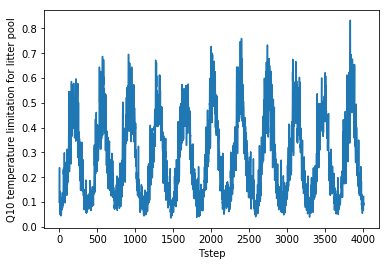

In [16]:
# - plot the temperature limitation function for the litter pool over time
plt.plot(ftemp_litter)
plt.xlabel('Tstep')
plt.ylabel('Q10 temperature limitation for litter pool')
plt.show()

We can see that the temperature limitation function varies between about 0 and 0.85 as it is supposed to do. 

To see the shape of the temperature limitation function we can plot a scatter plot between the function and the input temperature data. The example below is for the litter layer:

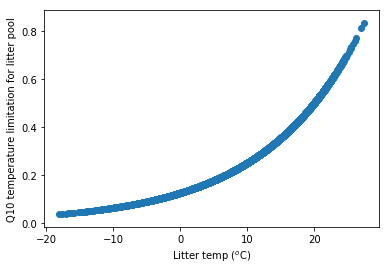

In [17]:
# - plot the relationship between the litter temperature and the temperature limitation function for the litter layer
plt.scatter(input_data.LITTER_TEMP-273.15, ftemp_litter)
plt.xlabel('Litter temp ($^{o}$C)')
plt.ylabel('Q10 temperature limitation for litter pool')
plt.show()

Again, from this plot we can see that the temperature limitation function varies between 0 and around 0.85.

**Exercise: in the box below, modify the code above to plot the temperature limitation function for the *soil* layer**

In [18]:
# - write code here

**Question: What do you notice about the difference between the litter and soil *temperature* limitation functions?**

ANSWER:

In [19]:
# -
# - moisture function
# -
fmoist_litter = np.maximum(Wf_min, Wf_max + Wf_m * ( (input_data.LITTER_MOIST - Wf_x0)**2 ))
fmoist_soil = np.maximum(Wf_min, Wf_max + Wf_m * ( (input_data.SOIL_MOIST - Wf_x0)**2 ))

As for the temperature limitation function, the above equations will calculate the moisture limitation function for the whole time series of the input moisture data. We can plot this below for the litter layer.

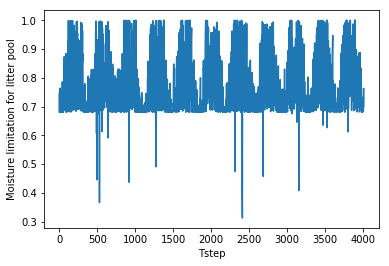

In [20]:
# - plot the moisture limitation function for the litter pool over time
plt.plot(fmoist_litter)
plt.xlabel('Tstep')
plt.ylabel('Moisture limitation for litter pool')
plt.show()

From this plot we can see that the moisture limitation function mostly varies between 0.68 and 1 but lower values are possible at times of low soil moisture.

To see the overall shape of the moisture limitation function we can plot a scatter plot between the function and the input temperature data. The example below is for the litter layer:

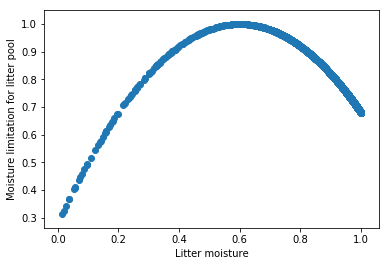

In [21]:
# - plot relationship between litter moisture and the moisture limitation fucntion for the litter pool
plt.scatter(input_data.LITTER_MOIST, fmoist_litter)
plt.xlabel('Litter moisture')
plt.ylabel('Moisture limitation for litter pool')
plt.show()

**Exercise: in the box below, modify the code above to plot the moisture limitation function for the soil layer**

In [22]:
# - write code here


**Question: What do you notice about the difference between the litter and soil *moisture* limitation functions?**

ANSWER:

-----------

### Model equations for calculation of C fluxes and changes in C stocks per timestep

Now we examine the equations for the heterotrophic respiration fluxes, the transfer of C between the two pools, and the resultant evolution of the two C pools over time. See the introduction to the model and powerpoint slides on "Biogeochemistry in TEMs" for more information.

#### General equation for C decomposed
\begin{equation*}
C_{tot\_decomp} = C_{pool_x}.\frac{\Delta t}{\tau_{pool_x}}.f(T)_{pool_x}.f(W)_{pool_x}\qquad(1)
\end{equation*}

Note: this total C that is decomposed will be split into C that is transferred to to another pool (this is the amount that corresponds to the microbial efficiency fraction) and C that is released via heterotrophic respiration (this equals the fraction that is 1 minus the microbial efficiency fraction).

#### C flux from litter to the soil C pool
\begin{equation*}
C_{litter \to soil} = C_{litter}.\frac{\Delta t}{\tau_{litter}}.f(T)_{litter}.f(W)_{litter}.M_{e,litter}\qquad(2)
\end{equation*}

where C$_{litter}$ is the C stock of the litter pool, *$\Delta$t* is the change in time (i.e. 1 timestep), $\tau_{litter}$ is the turnover time of the litter pool, *f(T)$_{litter}$* and *f(W)$_{litter}$* are the temperature and moisture limitations for the litter pool that we have already calculated, and *M*$_{e,litter}$ is the microbial efficiency of the litter pool (i.e. the fraction of C that gets transferred between pools).

#### Heterotrophic respiration (*R*$_{h,litter}$) from litter pool
\begin{equation*}
R_{h,litter} = C_{litter}.\frac{\Delta t}{\tau_{litter}}.f(T)_{litter}.f(W)_{litter}.(1 - M_{e,litter})\qquad(3)
\end{equation*}

where (*1-M*$_{e,litter}$) is the fraction of C that is respired and *not* transferred between pools.

#### C flux from the soil to the litter C pool
\begin{equation*}
C_{soil \to litter} = C_{soil}.\frac{\Delta t}{\tau_{soil}}.f(T)_{soil}.f(W)_{soil}.M_{e,soil}\qquad(4)
\end{equation*}

#### Heterotrophic respiration (*R*$_{h,soil}$) from soil pool
\begin{equation*}
R_{h,soil} = C_{soil}.\frac{\Delta t}{\tau_{soil}}.f(T)_{soil}.f(W)_{soil}.(1 - M_{e,soil})\qquad(5)
\end{equation*}


#### Change of C stock in litter pool
\begin{equation*}
\frac{dC_{litter}}{dt} = L_{input} - C_{litter \to soil} - R_{h,litter} + C_{soil \to litter}\qquad(6)
\end{equation*}

Note: C$_{litter \to soil}$ plus R$_{h,litter}$ equals the total amount of C decomposed from the litter pool (following Eq. 1).

#### Change of C stock in soil pool
\begin{equation*}
\frac{dC_{soil}}{dt} = C_{litter \to soil} - C_{soil \to litter} - R_{h,soil}\qquad(7)
\end{equation*}

Note: C$_{soil \to litter}$ plus R$_{h,soil}$ equals the total amount of C decomposed from the soil pool (following Eq. 1).

#### Total heterotrophic respiration (*R*$_{h,tot}$)
\begin{equation*}
R_{h,tot} = R_{h,litter} + R_{h,soil}\qquad(8)
\end{equation*}


Before we code these calculations into the model, we first need to "initialize" our model variables so we can keep track of the fluxes and C pools over time:

In [23]:
# -
# - initialize model variables
# -

# - litter and soil C pools (want to save time series)
Cpools = np.zeros((ntsteps+1, npools))
Cpools[0,0] = C_litter_t0
Cpools[0,1] = C_soil_t0

# - litter and soil Rh (want to save timeseries)
Rh = np.zeros((ntsteps, npools))

# - total C decomp each tstep
Cdecomp = np.zeros(npools)

# - total C transferred
Ctrans = np.zeros(npools)

**Now we can finally code the bulk of the model to calculate the changes in C pools and fluxes over time.**

As you can see from the equations above, each calculation is performed at each timestep; therefore, we need to *loop* over each timestep in the input files, calculate the fluxes between pools (and the heterotrophic respiration) and update the carbon stocks for each pool **at each timestep**. For this, we need a "for loop": https://en.wikipedia.org/wiki/For_loop. For loops iterate over each item in an array. In this case, the array is the time series of input data.

In [24]:
# -
# - begin model simulations
# -

# - set up for loop over total number of timesteps in input data
for nt in np.arange(ntsteps):
    
    # - calculate the total amount of C decomposed in each pool (prior to splitting between C transferred and Rh) (Eq. 1)
    Cdecomp[0] = Cpools[nt,0] * (dt/tau_litter) * ftemp_litter[nt] * fmoist_litter[nt]
    Cdecomp[1] = Cpools[nt,1] * (dt/tau_soil) * ftemp_soil[nt] * fmoist_soil[nt]
    
    # - calculate the fraction of C transferred from one pool to the other (Eqns. 2 and 4)
    Ctrans[0] = Cdecomp[0] * Me_litter
    Ctrans[1] = Cdecomp[1] * Me_soil
    
    # - calculate the heterotrophic respiration in each pool (Eqns. 3 and 5)
    Rh[nt,0] = Cdecomp[0] * (1. - Me_litter)
    Rh[nt,1] = Cdecomp[1] * (1. - Me_soil)
    
    # - calculate evolution of C pools (Eqns. 6 and 7) --> NOTE: updating C pool from current to next tstep
    Cpools[nt+1,0] = Cpools[nt,0] + input_data.LITTER_INPUT[nt] - Cdecomp[0] + Ctrans[1]
    Cpools[nt+1,1] = Cpools[nt,1] + Ctrans[0] - Cdecomp[1]

# -
# - end of the model
# -

-------
-------

## Plotting the results

Now we have looped over all the timesteps of the input data we can plot the results. 

In the box below I have plotted the *R$_{h}$* for the litter pool and the total C stock for both the litter and the soil pool.

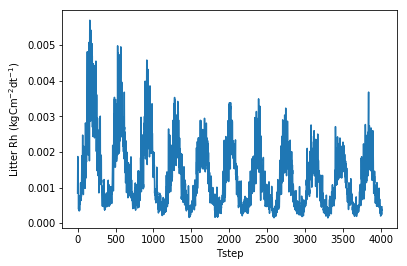

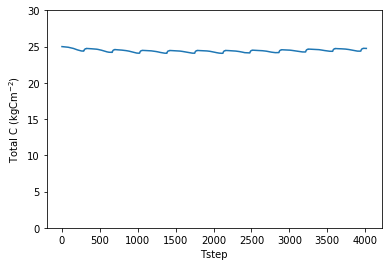

In [25]:
# - plot Rh_litter
plt.plot(Rh[:,0])
plt.xlabel('Tstep')
plt.ylabel('Litter Rh (kgCm$^{-2}$dt$^{-1}$)')
plt.show()

# - plot C stock for soil pool (changed axes limits to 0 to 30kgC/m2)
tot_Cpools = Cpools[:,0] + Cpools[:,1]    # - equivalent to np.sum(Cpools, axis=1) for those familiar with Python
plt.plot(tot_Cpools)
plt.xlabel('Tstep')
plt.ylabel('Total C (kgCm$^{-2}$)')
plt.ylim(0,30)
plt.show()

**Exercise: in the box below modify the code above to plot the soil Rh, the total Rh (litter + soil) and C for each pool (i.e. litter and soil separately) over time.** Change the axes titles and y-axis limits as needed.

In [26]:
# - write code here



Using all 6 plots above (R$_{h,litter}$, R$_{h,soil}$, R$_{h,tot}$, C$_{litter}$, C$_{soil}$ and C$_{tot}$), answer the following questions:

**Question: What causes the cyclical variations in the heterotrophic respiration fluxes?**

ANSWER:

**Question: Is the total Rh stable over time? If not, why is this?**

ANSWER:

**Question: How is the temporal evolution of the litter C pool different from the soil C pool? Why?**

ANSWER:

**That's it for this introductory exercise. Complete all the exercises and questions and upload your jupyter notebook to Canvas.**